# L1 Regularization
If the value of lambda is Zero then above Loss function becomes Ordinary Least Square whereas very large value makes the coefficients (weights) zero hence it under-fits.

###  Imports

In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
from torch.autograd import Variable
from torch import Tensor
from torchvision import datasets, transforms
import numpy as np
from sklearn import metrics
import math
import matplotlib.pyplot as plt
from pathlib import Path
import os

%matplotlib inline
%config InlineBackend.figure_format='retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [2]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


### Model

In [118]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)  
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    opt.zero_grad()
    pred = cl(x)
    pred.to(device)
    err = F.nll_loss(pred, y)
    #     L1 regularizer
    with torch.enable_grad():
        reg = 1e-05
        l1_loss = torch.zeros(1)
        for name, param in cl.named_parameters():
            if 'bias' not in name:  # param is a weight tensor
                l1_loss += reg*torch.sum(torch.abs(param))
    err += l1_loss.item()
    err.backward()
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

### Train classifier

In [119]:
num_epochs = 4
batch_size = 32
e_losses = [] 

# Load pre-trained model
cl = Classifier().to(device)

# optimizer
cl_opt = optim.Adam(cl.parameters(), lr=0.001)

for e in range(num_epochs):
    cl.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        c_error,c_pred = train_classifier(cl,cl_opt, data.to(device), target.to(device))
        e_losses.append(c_error.cpu().data.numpy())
    acc = test_model(cl,test_loader)
    print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")

print("Performance in the trained model: ")
acc_test = test_model(cl,test_loader)
print("Test accuracy: ", 100*acc_test, "%")
print("FINISHED!!!")


C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0 : Test accuracy:  97.31 %
Epoch  1 : Test accuracy:  98.52 %
Epoch  2 : Test accuracy:  98.79 %
Epoch  3 : Test accuracy:  98.78 %
Performance in the trained model: 
Test accuracy:  98.78 %
FINISHED!!!


### Save models

In [120]:
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/MNIST/FGSM/L1")
file = "l1_regularized_1e-05_model_3.pth"
torch.save(cl.state_dict(),  os.path.join(path, file))

# FGSM

### Imports

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


%matplotlib inline
%config InlineBackend.figure_format='retina'

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

### Inputs

In [4]:
### ONLY RUN ONCE AT THE BEGINNING! 
# The key 0 corresponds to 0 weight decay i.e. the vanilla model with 0 prune
# fgsm_regularized = {0: [0.9766, 0.8948, 0.7273, 0.513, 0.3179, 0.1715, 0.097]}

In [5]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/MNIST/FGSM/L1")
file = "l1_regularized_1e-01_model_3.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

### Model under attack

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)    

        
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)

### Make model sparse

In [7]:
model.fc3.state_dict()['weight']

tensor([[-0.0743,  0.0396, -0.0213,  ..., -0.0459, -0.0568, -0.0835],
        [-0.0947, -0.2025, -0.0441,  ...,  0.0030, -0.1991,  0.0995],
        [ 0.0805, -0.0362,  0.0602,  ..., -0.0583, -0.1212,  0.1018],
        ...,
        [-0.0934, -0.1879,  0.0654,  ...,  0.0011, -0.0183,  0.0559],
        [ 0.0731,  0.0518,  0.0501,  ...,  0.0735, -0.0333, -0.0242],
        [ 0.0054,  0.0080,  0.0257,  ..., -0.0263,  0.0273, -0.1224]],
       device='cuda:0')

In [11]:
threshold = 1e-03
count = 0
for name, param in model.named_parameters():
    if 'bias' not in name:
        with torch.no_grad():     # VIP: Otherwise, Leaf variable has been moved into graph interior error 
            shape = param.size()
            tensor = torch.flatten(param)
            print(shape, tensor.size())
            for i in range(tensor.size()[0]):
                if abs(tensor[i].item()) < threshold:
                    tensor[i] = torch.empty(1)
                    count += 1

print(count)

torch.Size([10, 1, 5, 5]) torch.Size([250])
torch.Size([20, 10, 5, 5]) torch.Size([5000])
torch.Size([512, 320]) torch.Size([163840])
torch.Size([200, 512]) torch.Size([102400])
torch.Size([10, 200]) torch.Size([2000])
33066


In [9]:
model.fc3.state_dict()['weight']

tensor([[-7.4349e-02,  3.9561e-02, -2.1328e-02,  ..., -4.5889e-02,
         -5.6773e-02, -8.3523e-02],
        [-9.4653e-02, -2.0248e-01, -4.4122e-02,  ...,  1.4013e-45,
         -1.9913e-01,  9.9473e-02],
        [ 8.0507e-02, -3.6212e-02,  6.0198e-02,  ..., -5.8287e-02,
         -1.2121e-01,  1.0182e-01],
        ...,
        [-9.3441e-02, -1.8789e-01,  6.5356e-02,  ...,  0.0000e+00,
         -1.8274e-02,  5.5904e-02],
        [ 7.3125e-02,  5.1818e-02,  5.0093e-02,  ...,  7.3525e-02,
         -3.3286e-02, -2.4218e-02],
        [ 1.4013e-45,  1.4013e-45,  2.5703e-02,  ..., -2.6322e-02,
          2.7256e-02, -1.2237e-01]], device='cuda:0')

### FGSM attack

In [129]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

### Run attack

In [130]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
#         print('output ', output)
#         print('target ', target)
#         print('loss', loss)
#         print('model ', model)
#         break
        loss.backward(retain_graph=True)
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [131]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
print(accuracies)

C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0	Test Accuracy = 9794 / 10000 = 0.9794
Epsilon: 0.05	Test Accuracy = 9308 / 10000 = 0.9308
Epsilon: 0.1	Test Accuracy = 8341 / 10000 = 0.8341
Epsilon: 0.15	Test Accuracy = 6776 / 10000 = 0.6776
Epsilon: 0.2	Test Accuracy = 4843 / 10000 = 0.4843
Epsilon: 0.25	Test Accuracy = 3105 / 10000 = 0.3105
Epsilon: 0.3	Test Accuracy = 1807 / 10000 = 0.1807
[0.9794, 0.9308, 0.8341, 0.6776, 0.4843, 0.3105, 0.1807]


### Results
DONT FORGET TO CHANGE THE WEIGHT DECAY KEY DICTIONARY

In [138]:
z = np.mean([
    [0.9766, 0.8948, 0.7273, 0.513, 0.3179, 0.1715, 0.097],
   [0.9731, 0.8894, 0.7239, 0.4802, 0.2585, 0.1197, 0.0653],
[0.9683, 0.8829, 0.7217, 0.5288, 0.3512, 0.2235, 0.1398]
], axis=0)
z

array([0.97266667, 0.88903333, 0.7243    , 0.50733333, 0.3092    ,
       0.17156667, 0.1007    ])

In [137]:
a = np.mean([
    [0.9783, 0.8945, 0.7187, 0.4817, 0.2728, 0.1508, 0.0988] ,
    [0.9836, 0.9385, 0.8365, 0.6695, 0.4625, 0.2796, 0.1537],
    [0.9794, 0.9308, 0.8341, 0.6776, 0.4843, 0.3105, 0.1807]

], axis=0)
a

array([0.98043333, 0.92126667, 0.79643333, 0.6096    , 0.40653333,
       0.24696667, 0.1444    ])

In [12]:
data = {
    0: [0.97245, 0.88885, 0.7245 , 0.5209 , 0.33455, 0.1975 , 0.1184 ],
#     '1e-01': [0.9815 , 0.93465, 0.8353 , 0.67355, 0.4734 , 0.29505, 0.1672 ],
#     '1e-02': [0.97365, 0.9154 , 0.79985, 0.6258 , 0.43105, 0.26625, 0.15845],
    '1e-03': [0.96155, 0.8614 , 0.68785, 0.4828 , 0.2919 , 0.1533 , 0.07725],
    '1e-04': [0.98355, 0.94355, 0.8608 , 0.7219 , 0.5337 , 0.3413 , 0.1929 ],
    '1e-05': [0.9818 , 0.9203 , 0.78475, 0.58415, 0.38195, 0.231  , 0.1254 ],
}

In [143]:
data = {
    0: [0.97266667, 0.88903333, 0.7243    , 0.50733333, 0.3092    ,
       0.17156667, 0.1007    ],
    '1e-01': [0.98043333, 0.92126667, 0.79643333, 0.6096    , 0.40653333,
       0.24696667, 0.1444    ],
    '1e-02': [0.97133333, 0.8949    , 0.76413333, 0.5875    , 0.3979    ,
       0.24703333, 0.15316667],
    '1e-03': [0.9552    , 0.83176667, 0.6357    , 0.44136667, 0.2825    ,
       0.17133333, 0.10353333],
    '1e-04': [0.97963333, 0.92166667, 0.81583333, 0.6638    , 0.4824    ,
       0.31036667, 0.1821    ],
    '1e-05': [0.96403333, 0.8723    , 0.72196667, 0.5333    , 0.35493333,
       0.2245    , 0.13143333],
}

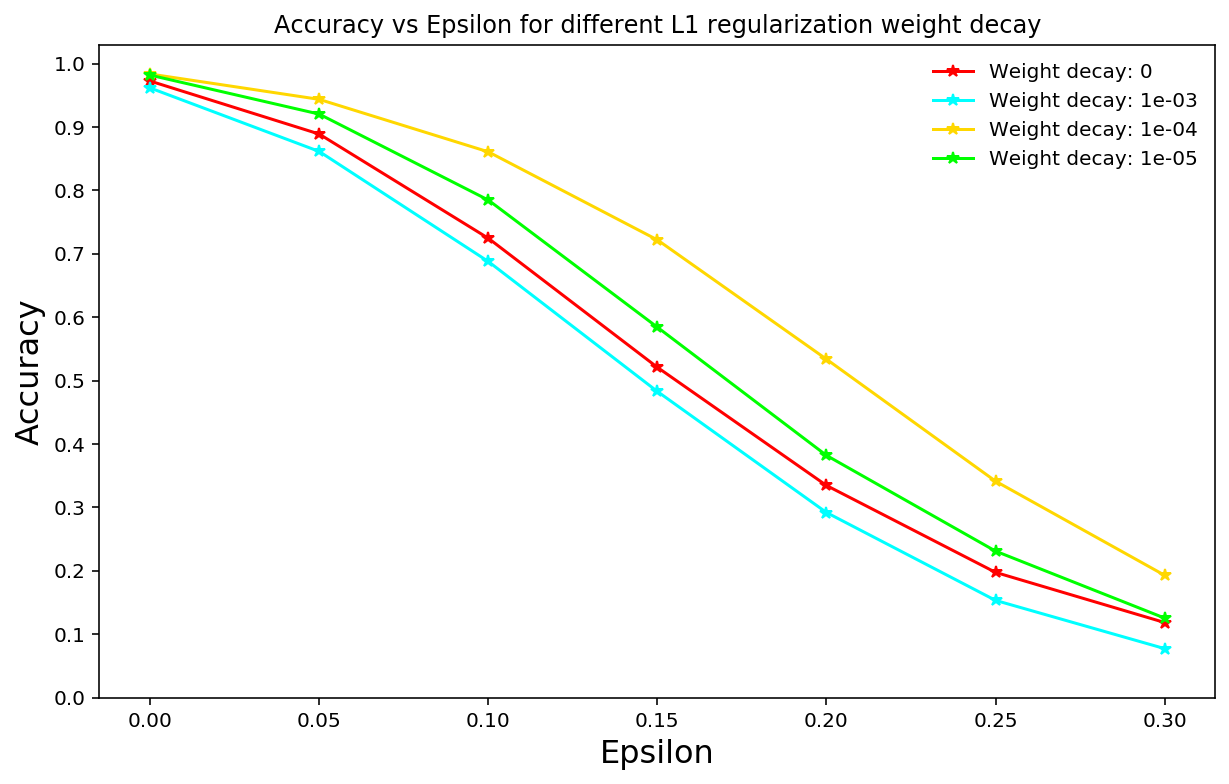

In [18]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime', 'darkorange', 'darkviolet']
# colors =  ['red', 'lime', 'aqua', 'darkviolet']

for idx, (decay, results) in enumerate(data.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="Weight decay: {}".format(decay))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon for different L1 regularization weight decay")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()